In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('ticks',
              {'grid.linestyle': 'none', 'axes.edgecolor': '0',
               'axes.linewidth': 1.2, 'legend.frameon': True,
               'xtick.direction': 'out', 'ytick.direction': 'out',
               'xtick.top': True, 'ytick.right': True,
              })


## starting in horizontal plane

In [2]:
wake_names = ['time', 'wakeZ', 'wakeX', 'wakeY']

## loading RW and geometric wakes
# rw. Index 0 meaning IDs open, index 1 --- IDs closed
wake_rw = pd.read_csv("./Impedance_files/rw_2_id_0_wake.sdds", sep='\\s+', skiprows=8, names=wake_names)
# geometric. Integrated in the name of the file means it's integrated over the ring
wake = pd.read_csv("./Impedance_files/integrated_LR_MAC9.sdds", sep='\\s+', skiprows=8, names=wake_names)

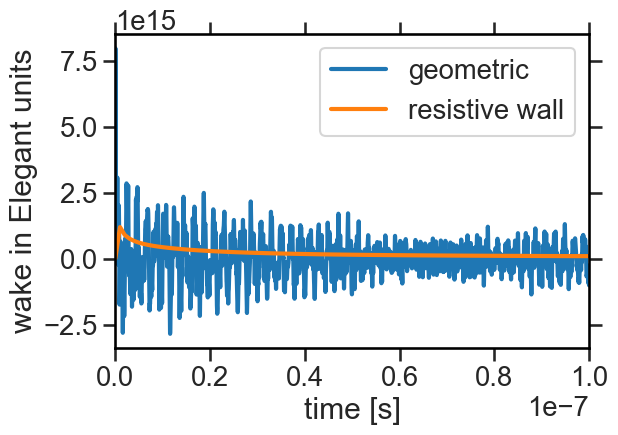

In [3]:
plt.plot(wake['time'], wake['wakeX'], label='geometric')
plt.plot(wake_rw['time'], wake_rw['wakeX'], label='resistive wall')

plt.xlim(0, 1e-7)

plt.ylabel('wake in Elegant units')
plt.xlabel('time [s]')

plt.legend()

plt.tight_layout()

In [4]:
## essentially takes FFT of wakes and re-orders the arrays, so the harmonics correspond to negative frequencies
def get_impedance(dataframe, direction='wakeX'):
    tmp = np.imag(np.fft.fft(dataframe[direction]))
    n = len(tmp)

    idxs = list(range(n // 2 + 1 if n % 2 else n // 2, n)) + list(range(0, n // 2 + 1 if n % 2 else n // 2))
    dt = (dataframe['time'].max() - dataframe['time'].min()) / n

    return tmp[idxs] * dt

In [5]:
## RW impedance
zx_rw = get_impedance(wake_rw)

## creating array of frequencies corresponding to RW impedance
dt = (wake_rw['time'].max() - wake_rw['time'].min()) / len(wake_rw['time'])
frq_rw = np.linspace(-0.5, 0.5, len(zx_rw)) / dt

In [6]:
## same for geometry

zx = get_impedance(wake)
dt = (wake['time'].max() - wake['time'].min()) / len(wake['time'])
frq = np.linspace(-0.5, 0.5, len(zx)) / dt

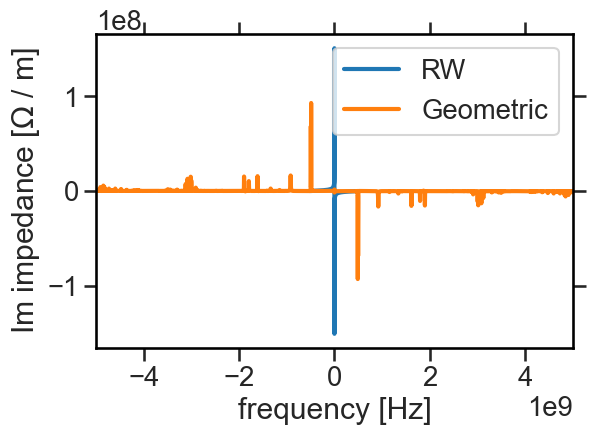

In [7]:
plt.plot(frq_rw, zx_rw, label='RW')
plt.plot(frq, zx, label='Geometric')

plt.xlim(-5e9, 5e9)

plt.xlabel('frequency [Hz]')
plt.ylabel(r'Im impedance [$\Omega$ / m]')
plt.legend()

plt.tight_layout()

In [8]:
## creating the array of frequencies 

d1 = (np.max(frq) - np.min(frq)) / len(frq)
d2 = (np.max(frq_rw) - np.min(frq_rw)) / len(frq_rw)

#frq_total = np.arange(np.min([np.min(frq_rw), np.min(frq)]), np.max([np.max(frq_rw), np.max(frq)]), np.min([d1,d2]))

## decided to use the span of -10  GHz to 10 GHz with the smallest step (between the arrays)
frq_total = np.arange(-10e9, 10e9, np.min([d1,d2]))

In [9]:
## total impedance = summation of interpolated RW and interpolated geometry
zx_total = np.interp(frq_total, frq_rw, zx_rw) + np.interp(frq_total, frq, zx)

C:\Users\fgt22338\AppData\Local\Temp\ipykernel_15692\333265357.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\fgt22338\AppData\Local\miniforge\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\fgt22338\AppData\Local\miniforge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


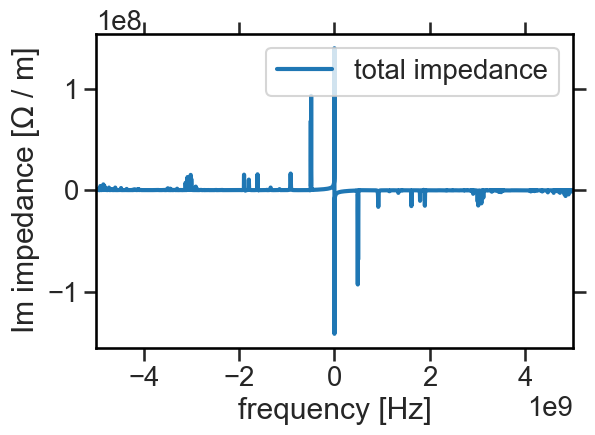

In [10]:
plt.plot(frq_total, zx_total, label='total impedance')

plt.xlim(-5e9, 5e9)

plt.xlabel('frequency [Hz]')
plt.ylabel(r'Im impedance [$\Omega$ / m]')
plt.legend()

plt.tight_layout()

In [11]:
nux = 54.14
nuy = 20.24128 # Open IDs
#nuy = 20.3277 # Closed IDs

x_factor = 0.11844020023
y_factor = 0.29330191974 # Open IDs
#y_factor = 0.26833644886 # Closed IDs

circum = 5.605610320953548e+02
E = 3.5 * 1e9 # in eV

## decided to use normalised to current
I0 = 1. #10e-3
c = 299792458.

omega_0 =  2 * np.pi / circum * c

n_bunch = 934

In [12]:
def growth_rate(mu, nu, impedance, frequency):
    
    p = np.arange(-100, 100)
    f0 = (c / circum)
    f = f0 * (mu + p * n_bunch + nu)
    
    #exp = power_s(f, mu, sigma_t)
    imp_interp = np.interp(f, frequency, impedance)

    return c * np.sum(imp_interp) / (2 * E * circum)

In [13]:
rate_x = [growth_rate(i, nux, zx_total, frq_total) for i in range(n_bunch)]

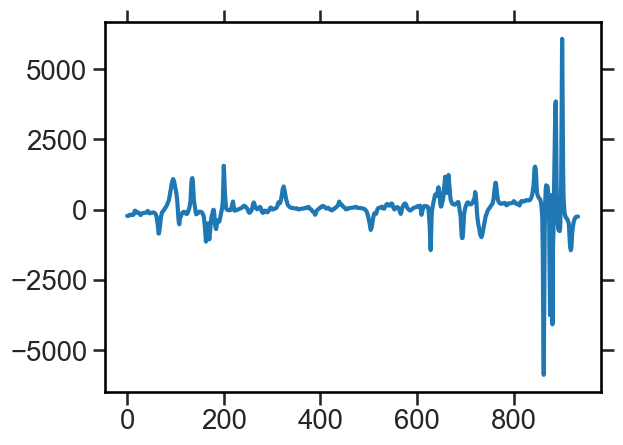

In [14]:
plt.plot(np.arange(n_bunch), rate_x)

## repeating in the vertical plane

In [15]:
zy_rw = get_impedance(wake_rw, direction='wakeY')
zy = get_impedance(wake, direction='wakeY')
zy_total = np.interp(frq_total, frq_rw, zy_rw) + np.interp(frq_total, frq, zy)

In [16]:
rate_y = [growth_rate(i, nuy, zy_total, frq_total) for i in range(n_bunch)]

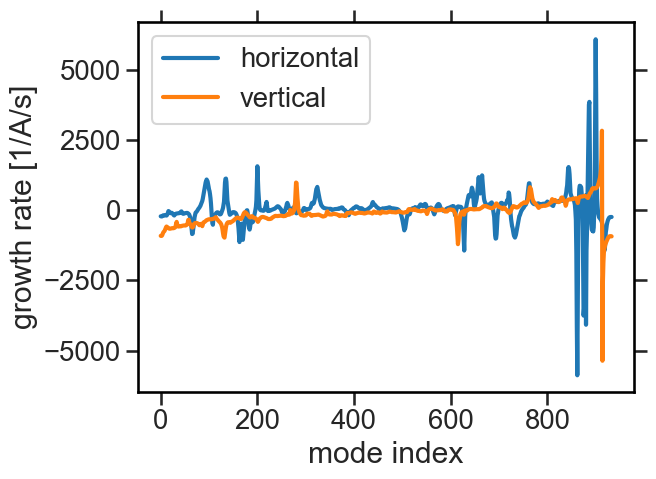

In [17]:
plt.plot(np.arange(n_bunch), rate_x, label='horizontal')
plt.plot(np.arange(n_bunch), rate_y, label='vertical')

plt.xlabel('mode index')
plt.ylabel('growth rate [1/A/s]')
plt.legend()
plt.legend()